In [ ]:
 #BASIC OBJECT DETECTION USING OPENCV AND HAAR CASCADES

In [1]:
import cv2

In [2]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
img = cv2.imread('/content/child.jfif')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

In [6]:
for (x, y, w, h) in faces:
       cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

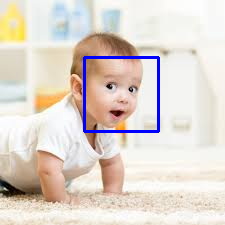

In [7]:
from google.colab.patches import cv2_imshow

# Assuming 'img' is already read
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#OBJECT DETECTION WITH YOLO (YOU ONLY LOOK ONCE)

In [9]:
import cv2
import numpy as np

In [8]:
import requests

# Function to download a file from a URL
def download_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print(f"Downloaded {filename}")

# URLs for the YOLO files
yolov3_cfg_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
yolov3_weights_url = "https://pjreddie.com/media/files/yolov3.weights"
coco_names_url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

# Download the files
download_file(yolov3_cfg_url, "yolov3.cfg")
download_file(yolov3_weights_url, "yolov3.weights")
download_file(coco_names_url, "coco.names")


Downloaded yolov3.cfg
Downloaded yolov3.weights
Downloaded coco.names


In [10]:
# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [11]:
# Load image
img = cv2.imread("/content/child.jfif")
height, width, channels = img.shape

In [12]:
# Convert image to blob
blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
net.setInput(blob)

In [13]:
# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [14]:
# Forward pass
outputs = net.forward(output_layers)

In [15]:
# Process detections
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)


In [16]:
# Apply Non-Maximum Suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

# Ensure indices is a valid format
if len(indices) > 0:
    indices = indices.flatten()  # Flatten the array to get a list of indices

    for i in indices:
        box = boxes[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
else:
    print("No objects detected.")


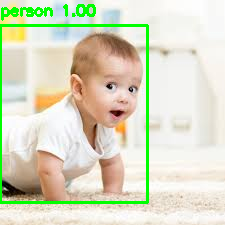

In [17]:
from google.colab.patches import cv2_imshow
import cv2

# Display the image
cv2_imshow(img)
cv2.waitKey(0)  # This is generally not needed in Colab
cv2.destroyAllWindows()  # This is generally not needed in Colab


In [ ]:
#MASK R-CNN FOR INSTANCE SEGMENTATION

In [18]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Load a pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 121MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [25]:
# Load the image
image = cv2.imread("/content/child.jfif")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [22]:
# Load and preprocess an input image
def load_and_preprocess_image(img_path):
    # Load an image file that contains an image to be classified
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    x = image.img_to_array(img)
    # Add a batch dimension
    x = np.expand_dims(x, axis=0)
    # Preprocess the input image
    x = preprocess_input(x)
    return x

In [26]:
# Transform the image to a tensor
image_tensor = F.to_tensor(image_rgb)

In [27]:
# Add a batch dimension
image_tensor = image_tensor.unsqueeze(0)

In [28]:
# Perform inference
with torch.no_grad():
    outputs = model(image_tensor)

In [29]:
# Get the masks, boxes, and labels
masks = outputs[0]['masks']
boxes = outputs[0]['boxes']
labels = outputs[0]['labels']
scores = outputs[0]['scores']

In [30]:
# Set the confidence threshold
conf_threshold = 0.5

In [31]:
# Loop over the detections
for i in range(len(masks)):
    if scores[i] > conf_threshold:
        # Extract the mask and bounding box
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        box = boxes[i].cpu().numpy().astype(int)
        label = labels[i].cpu().numpy()

        # Apply the mask to the image
        mask = cv2.resize(mask, (box[2] - box[0], box[3] - box[1]))
        mask = mask > 128

        roi = image[box[1]:box[3], box[0]:box[2]]
        roi[mask] = [0, 255, 0]

        # Draw the bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)


In [32]:
# Convert BGR image to RGB for displaying with matplotlib
output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

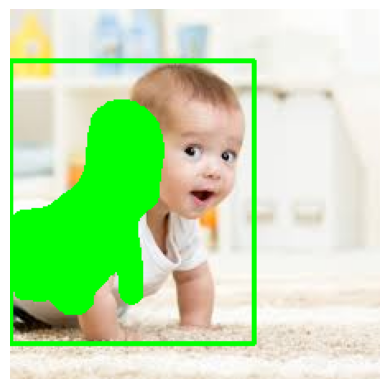

In [33]:
# Display the output image using matplotlib
plt.imshow(output_image)
plt.axis('off')  # Hide the axis
plt.show()